In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from scipy.signal import correlate2d
from skimage.data import shepp_logan_phantom

In [3]:
def intensityTransform(Y, X, X_full=None, idx=None):
    ''' Perform Linear Regression to transform X into Y
        Y: vector (N) - US
        X: data matrix (N, C) - MRI intensity & gradient
        
        returns intensity transformed X
    '''
    N = Y.shape[0]
    
    # X = [A B 1] Where A is intensity, B is gradient mag, and 1 is ones
    X_feat = None
    
    if X_full is None:
        X_feat = np.concatenate((X, np.ones((N, 1))), axis=1)
    else:
        # if using the neighborhood, create vectors for the 4 pixels surrounding a pixel + their 4 gradients
        # TODO
        
        # Currently, takes average value of intensity and average value of gradient neighborhoods
        k = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4
        intsty_nbhd = correlate2d(X_full[:, :, 0], k, mode='same', boundary='symm')
        intsty_nbhd = np.expand_dims(intsty_nbhd.reshape(-1)[idx], 1)
        grad_nbhd = correlate2d(X_full[:, :, 1], k, mode='same', boundary='symm').reshape(-1)
        grad_nbhd = np.expand_dims(grad_nbhd.reshape(-1)[idx], 1)
        X_feat = np.concatenate((X, intsty_nbhd, grad_nbhd, np.ones((N, 1))), axis=1)
    
    # w = pinv(X)*y  --->  y_hat = Xw
    params = np.linalg.pinv(X_feat)@Y
    print("params:", params)
    Y_hat = X_feat@params
    return Y_hat

# LC2 Code:
def lc2Similarity(img1, img2, extend=False):
    ''' img1: one channel image of size n*m (US)
        img2: multi-channel image of size n*m*c (MRI)
            c0 = image magnitude
            c1 = image gradient
        
        returns Linear Correlation of Linear Combination similarity measure:
        
    '''
    
    # Define similarity value
    similarity = -1
    
    img1 = img1.reshape(-1)
    img2_orig = img2
    img2 = img2.reshape(-1, img2.shape[2])
    
    num_pixels = img2.shape[0]
    idx = img1 > 0
    num_nonzero = np.sum(idx)
    
    Y = img1[idx]
    X = img2[idx]
    var_Y = np.var(Y)
    
    if var_Y > 1e-12:  # if variance is nonzero
        if num_nonzero > num_pixels/2:  # if more than half the pixels aren't zero
            if extend:
                Y_hat = intensityTransform(Y, X, X_full=img2_orig, idx=idx)
            else:
                Y_hat = intensityTransform(Y, X)
            mse = np.mean(np.power(Y - Y_hat, 2))
            print("mse:", mse)
            similarity = 1 - (np.var(Y - Y_hat) / var_Y)
            weight = np.sqrt(var_Y)
            measure = weight*similarity
    
    if (similarity == -1):
        similarity = 0
        weight = 0
        measure = 0
    
    return similarity, weight, measure


# LC2 assumes linear regression based on intensity + gradient + bias. What if we include neighborhood information?

# Two-stage matching process: geometric via SIFT + RANSAC (coarse), then iconic via LC2 (fine).

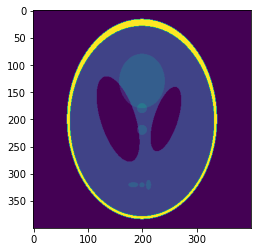

In [4]:
p = shepp_logan_phantom()
plt.imshow(p)

roll: (0, 0)
params: [1.00000000e+00 5.61534733e-15 6.48352899e-17]
mse: 4.126643556556249e-31
sim: 1.0 weight: 0.21391248947421587 measure: 0.21391248947421587

roll: (1, 5)
params: [ 0.37597817 -0.07865702  0.09140213]
mse: 0.03980135175436196
sim: 0.1301877132952277 weight: 0.21391248947421587 measure: 0.027848777849937632

roll: (3, 2)
params: [ 0.40876084 -0.04860838  0.08592736]
mse: 0.03847889114122454
sim: 0.1590885530729622 weight: 0.21391248947421587 measure: 0.03403102843468826

roll: (5, 5)
params: [ 0.28255552 -0.11498597  0.10572359]
mse: 0.042586478020777536
sim: 0.06932201552939865 weight: 0.21391248947421587 measure: 0.014828844917263918

roll: (0, 0)
params: [ 1.00000000e+00  4.06548710e-15  2.84841595e-15 -2.19420836e-15
 -1.98951099e-16]
mse: 1.7731201394146457e-30
sim: 1.0 weight: 0.21391248947421587 measure: 0.21391248947421587

roll: (1, 5)
params: [-0.14263697  0.02164251  0.66953855 -0.35051667  0.07628763]
mse: 0.03801918967768468
sim: 0.16913479430795486 weig

Text(0.5, 0.98, 'Noisy extended-LC2 evaluation')

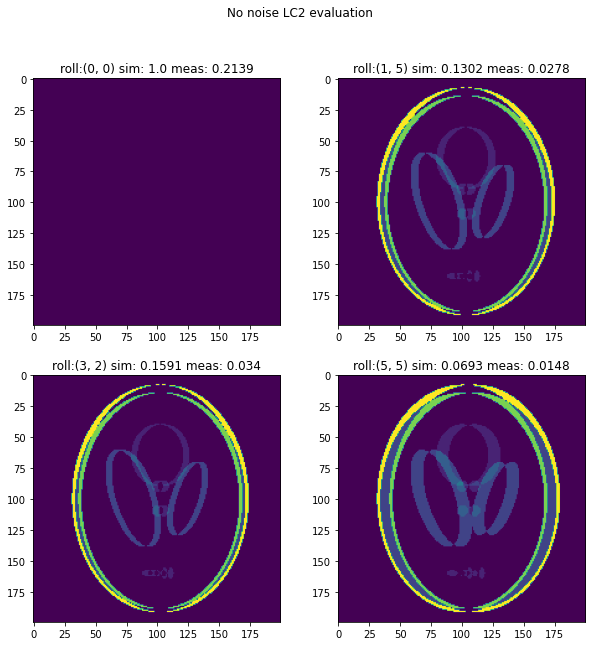

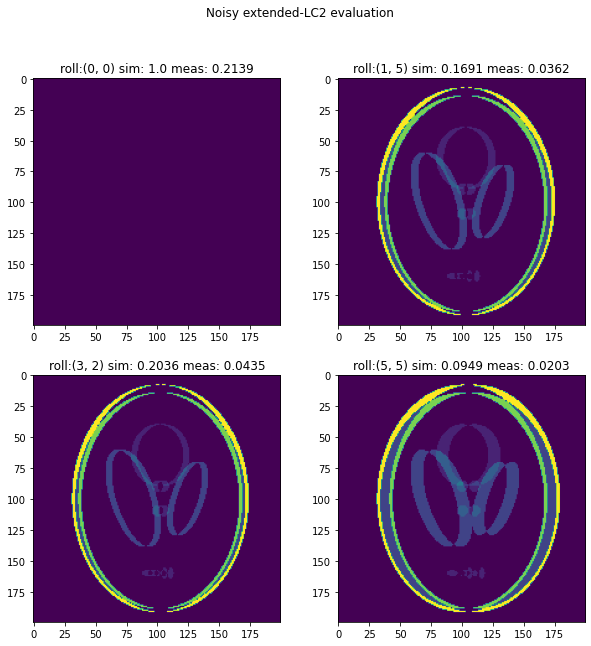

In [5]:
p = shepp_logan_phantom()
p = p[::2, ::2] + 0.02 # downsample by 2

# MRI (intensity and gradient)
p_grad = np.gradient(p)
p_grad = np.sqrt(np.power(p_grad[0], 2) + np.power(p_grad[1], 2))
p_mri = np.zeros((*p.shape, 2))
p_mri[:, :, 0] = p
p_mri[:, :, 1] = p_grad

# ROLL ONLY
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
ps = []
meas = []
for i in range(4):
    print("roll:", rolls[i])
    ps.append(np.roll(p, rolls[i]))
    similarity, weight, measure = lc2Similarity(ps[-1], p_mri)
    print("sim:", similarity, "weight:", weight, "measure:", measure)
    print()
    sims.append(similarity)
    meas.append(measure)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)) + ' meas: ' + str(round(meas[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("No noise LC2 evaluation")

# ROLL + EXTEND
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
ps = []
meas = []
for i in range(4):
    print("roll:", rolls[i])
    ps.append(np.roll(p, rolls[i]))
    similarity, weight, measure = lc2Similarity(ps[-1], p_mri, extend=True)
    print("sim:", similarity, "weight:", weight, "measure:", measure)
    print()
    sims.append(similarity)
    meas.append(measure)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)) + ' meas: ' + str(round(meas[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("Noisy extended-LC2 evaluation")


roll: (0, 0)
params: [0.8126805  0.07122802 0.12125482]
mse: 0.023542706191410686
sim: 0.6304427129089367 weight: 0.25239881187996216 measure: 0.15912299169659572

roll: (1, 5)
params: [0.25733804 0.06509089 0.22926039]
mse: 0.06012655446779281
sim: 0.05617450387426692 weight: 0.25239881187996216 measure: 0.014178378035811302

roll: (3, 2)
params: [0.29739474 0.09310239 0.22150288]
mse: 0.05878722760974419
sim: 0.07719834013864779 weight: 0.25239881187996216 measure: 0.019484769330099894

roll: (5, 5)
params: [ 0.18413184 -0.02697229  0.24494222]
mse: 0.06219711132520332
sim: 0.023672319598119884 weight: 0.2523988118799622 measure: 0.005974865341008204

roll: (0, 0)
params: [ 0.89680385 -0.05547272 -0.13237066  0.24509499  0.12600701]
mse: 0.023368984362216204
sim: 0.6331696792731109 weight: 0.25239881187996216 measure: 0.15981127476694987

roll: (1, 5)
params: [-0.11786857  0.01231808  0.4549366  -0.01226874  0.21773481]
mse: 0.05924815804292261
sim: 0.06996296969999893 weight: 0.2523

Text(0.5, 0.98, 'Noisy extended-LC2 evaluation')

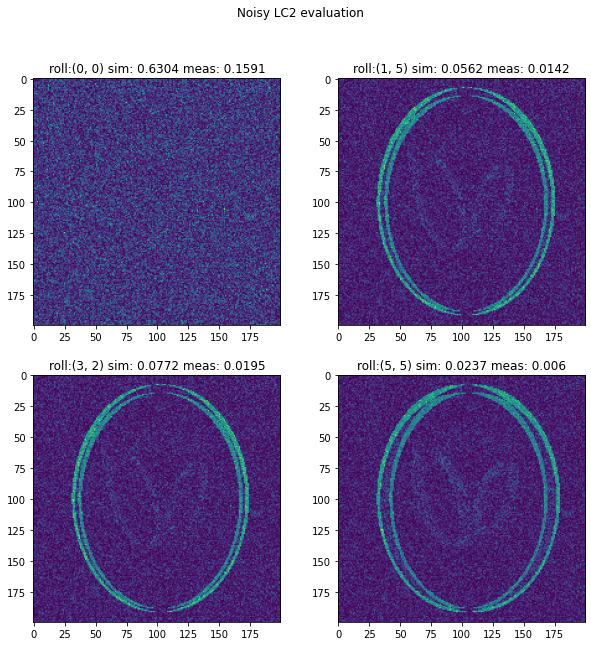

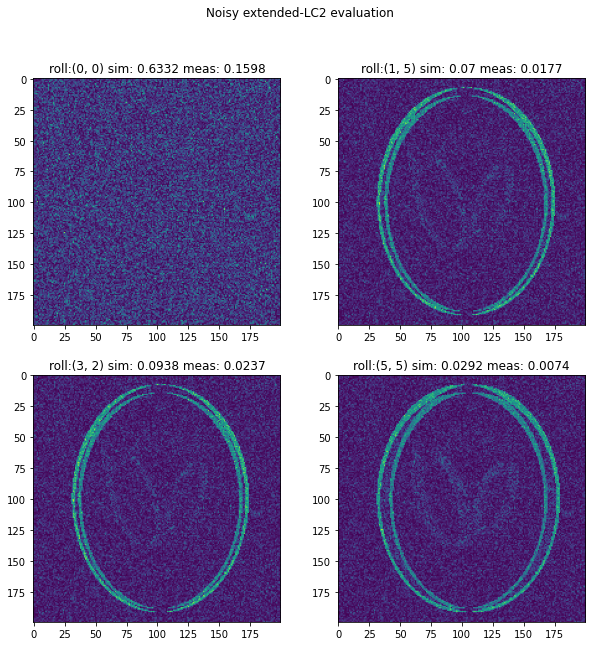

In [6]:
# ROLL + NOISE
noisy_p = p + 0.2*np.random.normal(0, 1, size=p.shape)
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
noisy_ps = []
meas = []
for i in range(4):
    print("roll:", rolls[i])
    noisy_ps.append(np.roll(noisy_p, rolls[i]))
    similarity, weight, measure = lc2Similarity(noisy_ps[-1], p_mri)
    print("sim:", similarity, "weight:", weight, "measure:", measure)
    print()
    sims.append(similarity)
    meas.append(measure)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(noisy_ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)) + ' meas: ' + str(round(meas[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("Noisy LC2 evaluation")

# ROLL + NOISE + EXTEND
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
noisy_ps = []
meas = []
for i in range(4):
    print("roll:", rolls[i])
    noisy_ps.append(np.roll(noisy_p, rolls[i]))
    similarity, weight, measure = lc2Similarity(noisy_ps[-1], p_mri, extend=True)
    print("sim:", similarity, "weight:", weight, "measure:", measure)
    print()
    sims.append(similarity)
    meas.append(measure)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(noisy_ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)) + ' meas: ' + str(round(meas[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("Noisy extended-LC2 evaluation")

In [8]:
model = keras.Sequential()
model.add(keras.layers.Dense(400, input_shape=(80000,), activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(40000, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(p_mri.reshape(-1)[np.newaxis, :], noisy_p.reshape(-1)[np.newaxis, :], epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 327ms/step - loss: 0.1066 - mse: 0.1066
Epoch 2/100
1/1 [==============================] - 0s 99ms/step - loss: 0.1068 - mse: 0.1068
Epoch 3/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0719 - mse: 0.0719
Epoch 4/100
1/1 [==============================] - 0s 99ms/step - loss: 0.0440 - mse: 0.0440
Epoch 5/100
1/1 [==============================] - 0s 102ms/step - loss: 0.0193 - mse: 0.0193
Epoch 6/100
1/1 [==============================] - 0s 99ms/step - loss: 0.0141 - mse: 0.0141
Epoch 7/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0133 - mse: 0.0133
Epoch 8/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0112 - mse: 0.0112
Epoch 9/100
1/1 [==============================] - 0s 102ms/step - loss: 0.0093 - mse: 0.0093
Epoch 10/100
1/1 [==============================] - 0s 105ms/step - loss: 0.0068 - mse: 0.0068
Epoch 11/100
1/1 [==============================] - 0s 103ms/s

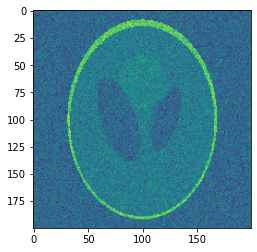

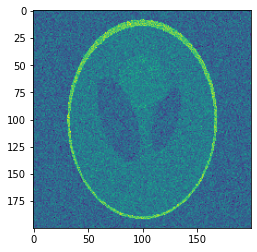

In [9]:
noisy_p_predict = model.predict(p_mri.reshape(-1)[np.newaxis, :])
plt.imshow(noisy_p_predict.reshape(p.shape))
plt.figure()
plt.imshow(noisy_p)